In [1]:
from __future__ import unicode_literals
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
import itertools
from math import factorial
import datetime

#now = datetime.datetime.now()


In [2]:
def _embed(x, order=3, delay=1):
    """Time-delay embedding.
    Parameters
    ----------
    x : 1d-array, shape (n_times)
        Time series
    order : int
        Embedding dimension (order)
    delay : int
        Delay.
    Returns
    -------
    embedded : ndarray, shape (n_times - (order - 1) * delay, order)
        Embedded time-series.
    """
    N = len(x)
    Y = np.empty((order, N - (order - 1) * delay))
    for i in range(order):
        Y[i] = x[i * delay:i * delay + Y.shape[1]]
    return Y.T


def util_pattern_space(time_series, lag, dim):
    """Create a set of sequences with given lag and dimension
    Args:
       time_series: Vector or string of the sample data
       lag: Lag between beginning of sequences
       dim: Dimension (number of patterns)
    Returns:
        2D array of vectors
    """
    n = len(time_series)

    if lag * dim > n:
        raise Exception('Result matrix exceeded size limit, try to change lag or dim.')
    elif lag < 1:
        raise Exception('Lag should be greater or equal to 1.')

    pattern_space = np.empty((n - lag * (dim - 1), dim))
    for i in range(n - lag * (dim - 1)):
        for j in range(dim):
            pattern_space[i][j] = time_series[i + j * lag]

    return pattern_space


def util_standardize_signal(time_series):
    return (time_series - np.mean(time_series)) / np.std(time_series)


def util_granulate_time_series(time_series, scale):
    """Extract coarse-grained time series
    Args:
        time_series: Time series
        scale: Scale factor
    Returns:
        Vector of coarse-grained time series with given scale factor
    """
    n = len(time_series)
    b = int(np.fix(n / scale))
    temp = np.reshape(time_series[0:b*scale], (b, scale))
    cts = np.mean(temp, axis = 1)
    return cts


def shannon_entropy(time_series):
    """Return the Shannon Entropy of the sample data.
    Args:
        time_series: Vector or string of the sample data
    Returns:
        The Shannon Entropy as float value
    """

    # Check if string
    if not isinstance(time_series, str):
        time_series = list(time_series)

    # Create a frequency data
    data_set = list(set(time_series))
    freq_list = []
    for entry in data_set:
        counter = 0.
        for i in time_series:
            if i == entry:
                counter += 1
        freq_list.append(float(counter) / len(time_series))

    # Shannon entropy
    ent = 0.0
    for freq in freq_list:
        ent += freq * np.log2(freq)
    ent = -ent
    return ent


def sample_entropy(time_series, sample_length, tolerance = None):
    """Calculates the sample entropy of degree m of a time_series.
    This method uses chebychev norm.
    It is quite fast for random data, but can be slower is there is
    structure in the input time series.
    Args:
        time_series: numpy array of time series
        sample_length: length of longest template vector
        tolerance: tolerance (defaults to 0.1 * std(time_series)))
    Returns:
        Array of sample entropies:
            SE[k] is ratio "#templates of length k+1" / "#templates of length k"
            where #templates of length 0" = n*(n - 1) / 2, by definition
    Note:
        The parameter 'sample_length' is equal to m + 1 in Ref[1].
    References:
        [1] http://en.wikipedia.org/wiki/Sample_Entropy
        [2] http://physionet.incor.usp.br/physiotools/sampen/
        [3] Madalena Costa, Ary Goldberger, CK Peng. Multiscale entropy analysis
            of biological signals
    """
    #The code below follows the sample length convention of Ref [1] so:
    M = sample_length - 1;

    time_series = np.array(time_series)
    if tolerance is None:
        tolerance = 0.1*np.std(time_series)

    n = len(time_series)

    #Ntemp is a vector that holds the number of matches. N[k] holds matches templates of length k
    Ntemp = np.zeros(M + 2)
    #Templates of length 0 matches by definition:
    Ntemp[0] = n*(n - 1) / 2


    for i in range(n - M - 1):
        template = time_series[i:(i+M+1)];#We have 'M+1' elements in the template
        rem_time_series = time_series[i+1:]

        searchlist = np.nonzero(np.abs(rem_time_series - template[0]) < tolerance)[0]

        go = len(searchlist) > 0;

        length = 1;

        Ntemp[length] += len(searchlist)

        while go:
            length += 1
            nextindxlist = searchlist + 1;
            nextindxlist = nextindxlist[nextindxlist < n - 1 - i]#Remove candidates too close to the end
            nextcandidates = rem_time_series[nextindxlist]
            hitlist = np.abs(nextcandidates - template[length-1]) < tolerance
            searchlist = nextindxlist[hitlist]

            Ntemp[length] += np.sum(hitlist)

            go = any(hitlist) and length < M + 1


    sampen =  - np.log(Ntemp[1:] / Ntemp[:-1])
    return sampen


def multiscale_entropy(time_series, sample_length, tolerance = None, maxscale = None):
    """Calculate the Multiscale Entropy of the given time series considering
    different time-scales of the time series.
    Args:
        time_series: Time series for analysis
        sample_length: Bandwidth or group of points
        tolerance: Tolerance (default = 0.1*std(time_series))
    Returns:
        Vector containing Multiscale Entropy
    Reference:
        [1] http://en.pudn.com/downloads149/sourcecode/math/detail646216_en.html
    """

    if tolerance is None:
        #we need to fix the tolerance at this level. If it remains 'None' it will be changed in call to sample_entropy()
        tolerance = 0.5*np.std(time_series) #originally defaulted at 0.1 but can be changed to 0.25
    if maxscale is None:
        maxscale = len(time_series)

    mse = np.zeros(maxscale)

    for i in range(maxscale): #skip every 20, less resolution but faster processing 
        now = datetime.datetime.now()
        if i == 0:
            print(now.strftime("%H:%M:%S"))
        elif i % 100 == 0:
            print(now.strftime("%H:%M:%S"))
        #print('index', i)
        temp = util_granulate_time_series(time_series, i+1)
        #print('granulated', i)
        mse[i] = sample_entropy(temp, sample_length, tolerance)[-1]
        #print('samp_ent', i)
    return mse


def permutation_entropy(time_series, order=3, delay=1, normalize=False):
    """Permutation Entropy.
    Parameters
    ----------
    time_series : list or np.array
        Time series
    order : int
        Order of permutation entropy
    delay : int
        Time delay
    normalize : bool
        If True, divide by log2(factorial(m)) to normalize the entropy
        between 0 and 1. Otherwise, return the permutation entropy in bit.
    Returns
    -------
    pe : float
        Permutation Entropy
    References
    ----------
    .. [1] Massimiliano Zanin et al. Permutation Entropy and Its Main
        Biomedical and Econophysics Applications: A Review.
        http://www.mdpi.com/1099-4300/14/8/1553/pdf
    .. [2] Christoph Bandt and Bernd Pompe. Permutation entropy — a natural
        complexity measure for time series.
        http://stubber.math-inf.uni-greifswald.de/pub/full/prep/2001/11.pdf
    Notes
    -----
    Last updated (Oct 2018) by Raphael Vallat (raphaelvallat9@gmail.com):
    - Major speed improvements
    - Use of base 2 instead of base e
    - Added normalization
    Examples
    --------
    1. Permutation entropy with order 2
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value between 0 and log2(factorial(order))
        >>> print(permutation_entropy(x, order=2))
            0.918
    2. Normalized permutation entropy with order 3
        >>> x = [4, 7, 9, 10, 6, 11, 3]
        >>> # Return a value comprised between 0 and 1.
        >>> print(permutation_entropy(x, order=3, normalize=True))
            0.589
    """
    x = np.array(time_series)
    hashmult = np.power(order, np.arange(order))
    # Embed x and sort the order of permutations
    sorted_idx = _embed(x, order=order, delay=delay).argsort(kind='quicksort')
    # Associate unique integer to each permutations
    hashval = (np.multiply(sorted_idx, hashmult)).sum(1)
    # Return the counts
    _, c = np.unique(hashval, return_counts=True)
    # Use np.true_divide for Python 2 compatibility
    p = np.true_divide(c, c.sum())
    pe = -np.multiply(p, np.log2(p)).sum()
    if normalize:
        pe /= np.log2(factorial(order))
    return pe


def multiscale_permutation_entropy(time_series, m, delay, scale):
    """Calculate the Multiscale Permutation Entropy
    Args:
        time_series: Time series for analysis
        m: Order of permutation entropy
        delay: Time delay
        scale: Scale factor
    Returns:
        Vector containing Multiscale Permutation Entropy
    Reference:
        [1] Francesco Carlo Morabito et al. Multivariate Multi-Scale Permutation Entropy for
            Complexity Analysis of Alzheimer’s Disease EEG. www.mdpi.com/1099-4300/14/7/1186
        [2] http://www.mathworks.com/matlabcentral/fileexchange/37288-multiscale-permutation-entropy-mpe/content/MPerm.m
    """
    mspe = []
    for i in range(scale):
        coarse_time_series = util_granulate_time_series(time_series, i + 1)
        pe = permutation_entropy(coarse_time_series, order=m, delay=delay)
        mspe.append(pe)
    return mspe


# TODO add tests
def composite_multiscale_entropy(time_series, sample_length, scale, tolerance=None):
    """Calculate the Composite Multiscale Entropy of the given time series.
    Args:
        time_series: Time series for analysis
        sample_length: Number of sequential points of the time series
        scale: Scale factor
        tolerance: Tolerance (default = 0.1...0.2 * std(time_series))
    Returns:
        Vector containing Composite Multiscale Entropy
    Reference:
        [1] Wu, Shuen-De, et al. "Time series analysis using
            composite multiscale entropy." Entropy 15.3 (2013): 1069-1084.
    """
    cmse = np.zeros((1, scale))

    for i in range(scale):
        for j in range(i):
            tmp = util_granulate_time_series(time_series[j:], i + 1)
            cmse[i] += sample_entropy(tmp, sample_length, tolerance) / (i + 1)
    return cmse

In [11]:
a1 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/BerliozSymphResamp.wav")
arr1 = np.array(a1[1],dtype=float)
arr1 = np.mean(arr1,axis=1)

a2 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/CalvinHarrisResamp.wav")
arr2 = np.array(a2[1],dtype=float)
arr2 = np.mean(arr2,axis=1)

a3 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/HermitThrushResamp.wav")
arr3 = np.array(a3[1],dtype=float)
arr3 = np.mean(arr3,axis=1)

a4 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/TEDSynthResamp.wav")
arr4 = np.array(a4[1],dtype=float)
#arr4 = np.mean(arr4,axis=1)

a5 = read("/Users/cogmech/Documents/Neuro Complexity Matching/ResampledAudio/ResampledAudio/TEDTalkResamp.wav")
arr5 = np.array(a5[1],dtype=float)
arr5 = np.mean(arr5,axis=1)

In [86]:
mse1 = multiscale_entropy(arr1, 3, None, 2048)
#mse2 = multiscale_entropy(arr2, 3, None, 2048)
#mse3 = multiscale_entropy(arr3, 3, None, 2048)
mse4 = multiscale_entropy(arr4, 3, None, 2048)
mse5 = multiscale_entropy(arr5, 3, None, 2048)

15:24:00
16:24:43
16:25:11
16:25:23
16:25:30
16:25:35
16:25:40
16:25:43
16:25:46
16:25:48
16:25:50
16:25:52
16:25:54
16:25:55
16:25:57
16:25:58
16:25:59
16:26:00
16:26:01
16:26:02
16:26:03
16:26:04
18:10:16
18:10:48
18:11:02
18:11:11
18:11:17
18:11:23
18:11:27
18:11:30
18:11:33
18:11:35
18:11:37
18:11:39
18:11:41
18:11:43
18:11:44
18:11:46
18:11:47
18:11:48
18:11:49
18:11:50
18:11:51
19:44:06
19:44:33
19:44:45
19:44:53
19:44:58
19:45:02
19:45:06
19:45:09
19:45:11
19:45:13
19:45:15
19:45:17
19:45:18
19:45:20
19:45:21
19:45:22
19:45:23
19:45:24
19:45:25
19:45:26


In [72]:
mse_1 = multiscale_entropy(arr1[0:140000], 3, None, 2048)
mse_2 = multiscale_entropy(arr2[0:140000], 3, None, 2048)
mse_3 = multiscale_entropy(arr3[0:140000], 3, None, 2048)
mse_4 = multiscale_entropy(arr4[0:140000], 3, None, 2048)
mse_5 = multiscale_entropy(arr5[0:140000], 3, None, 2048)

12:01:44
12:04:39
12:04:43
12:04:44
12:04:46
12:04:47
12:04:47
12:04:48
12:04:48
12:04:49
12:04:49
12:04:50
12:04:50
12:04:50
12:04:51
12:04:51
12:04:51
12:04:51
12:04:52
12:04:52
12:04:52
12:04:52
12:07:57
12:08:01
12:08:03
12:08:04
12:08:05
12:08:06
12:08:06
12:08:07
12:08:07
12:08:08
12:08:08
12:08:09
12:08:09
12:08:09
12:08:09
12:08:10
12:08:10
12:08:10
12:08:10
12:08:10
12:08:11
12:10:22
12:10:26
12:10:28
12:10:29
12:10:30
12:10:31
12:10:31
12:10:32
12:10:32
12:10:33
12:10:33
12:10:34
12:10:34
12:10:34
12:10:34
12:10:35
12:10:35
12:10:35
12:10:35
12:10:35
12:10:36
12:14:26
12:14:30
12:14:32
12:14:33
12:14:34
12:14:35
12:14:36
12:14:37
12:14:37
12:14:38
12:14:38
12:14:38
12:14:39
12:14:39
12:14:39
12:14:40
12:14:40
12:14:40
12:14:41
12:14:41
12:14:41
12:18:40
12:18:44
12:18:46
12:18:48
12:18:49
12:18:50
12:18:50
12:18:51
12:18:51
12:18:52
12:18:52
12:18:53
12:18:53
12:18:53
12:18:54
12:18:54
12:18:54
12:18:55
12:18:55
12:18:55


In [81]:
testmse_1 = multiscale_entropy(arr1[0:140000], 3, None, 2048)
testmse_2 = multiscale_entropy(arr2[0:140000], 3, None, 2048)
testmse_3 = multiscale_entropy(arr3[0:140000], 3, None, 2048)
testmse_4 = multiscale_entropy(arr4[0:140000], 3, None, 2048)
testmse_5 = multiscale_entropy(arr5[0:140000], 3, None, 2048)

12:41:09
12:42:59
12:43:03
12:43:05
12:43:06
12:43:07
12:43:08
12:43:08
12:43:09
12:43:09
12:43:10
12:43:10
12:43:11
12:43:11
12:43:11
12:43:12
12:43:12
12:43:12
12:43:12
12:43:12
12:43:13
12:43:13
12:45:26
12:45:29
12:45:31
12:45:33
12:45:33
12:45:34
12:45:35
12:45:35
12:45:36
12:45:36
12:45:37
12:45:37
12:45:37
12:45:38
12:45:38
12:45:38
12:45:38
12:45:39
12:45:39
12:45:39
12:45:39
12:47:10
12:47:14
12:47:16
12:47:17
12:47:18
12:47:19
12:47:19
12:47:20
12:47:20
12:47:21
12:47:21
12:47:21
12:47:22
12:47:22
12:47:22
12:47:22
12:47:23
12:47:23
12:47:23
12:47:23
12:47:23
12:50:13
12:50:17
12:50:19
12:50:20
12:50:21
12:50:22
12:50:22
12:50:23
12:50:23
12:50:24
12:50:24
12:50:24
12:50:25
12:50:25
12:50:25
12:50:25
12:50:26
12:50:26
12:50:26
12:50:26
12:50:26
12:53:28
12:53:32
12:53:34
12:53:36
12:53:37
12:53:38
12:53:39
12:53:39
12:53:40
12:53:40
12:53:41
12:53:41
12:53:41
12:53:42
12:53:42
12:53:42
12:53:43
12:53:43
12:53:43
12:53:43


Text(0.5, 1.0, 'Log-Log Stimuli MSE')

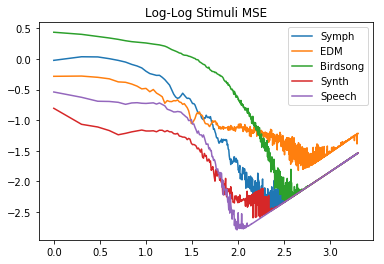

In [82]:
plt.plot(np.log10(range(1,2001)),np.log10(testmse_1[0:2000]),np.log10(range(1,2001)),np.log10(testmse_2[0:2000]),np.log10(range(1,2001)),np.log10(testmse_3[0:2000]),np.log10(range(1,2001)),np.log10(testmse_4[0:2000]),np.log10(range(1,2001)),np.log10(testmse_5[0:2000]))
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('Log-Log Stimuli MSE')

Text(0.5, 1.0, 'X-Log Stimuli MSE')

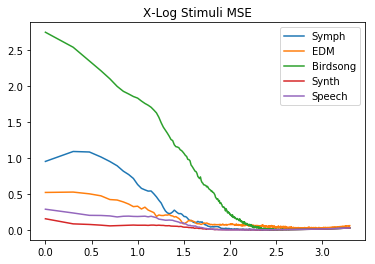

In [83]:
plt.plot(np.log10(range(1,2001)),testmse_1[0:2000],np.log10(range(1,2001)),testmse_2[0:2000],np.log10(range(1,2001)),testmse_3[0:2000],np.log10(range(1,2001)),testmse_4[0:2000],np.log10(range(1,2001)),testmse_5[0:2000])
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('X-Log Stimuli MSE')

Text(0.5, 1.0, 'Log-Log Stimuli MSE')

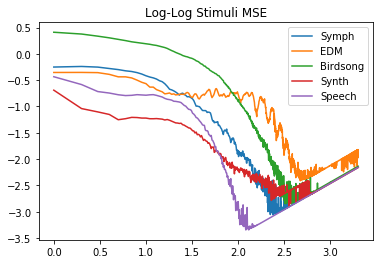

In [87]:
import math

plt.plot(np.log10(range(1,2001)),np.log10(mse1[0:2000]),np.log10(range(1,2001)),np.log10(mse2[0:2000]),np.log10(range(1,2001)),np.log10(mse3[0:2000]),np.log10(range(1,2001)),np.log10(mse4[0:2000]),np.log10(range(1,2001)),np.log10(mse5[0:2000]))
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('Log-Log Stimuli MSE')

Text(0.5, 1.0, 'Log-Log Stimuli MSE')

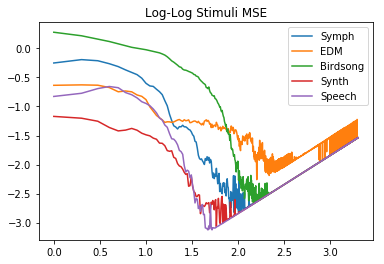

In [75]:
plt.plot(np.log10(range(1,2001)),np.log10(mse_1[0:2000]),np.log10(range(1,2001)),np.log10(mse_2[0:2000]),np.log10(range(1,2001)),np.log10(mse_3[0:2000]),np.log10(range(1,2001)),np.log10(mse_4[0:2000]),np.log10(range(1,2001)),np.log10(mse_5[0:2000]))
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('Log-Log Stimuli MSE')

Text(0.5, 1.0, 'X-Log Stimuli MSE')

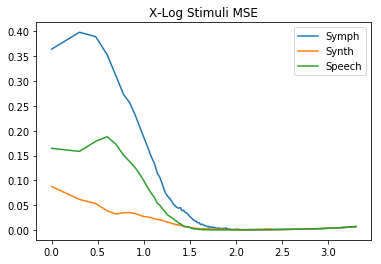

In [55]:
plt.plot(np.log10(range(1,2001)),mse1[0:2000],np.log10(range(1,2001)),mse4[0:2000],np.log10(range(1,2001)),mse5[0:2000])
plt.legend(['Symph','Synth','Speech'])
plt.title('X-Log Stimuli MSE')

Text(0.5, 1.0, 'X-Log Stimuli MSE')

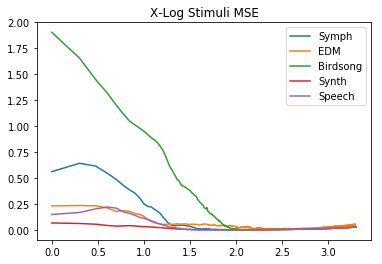

In [76]:
plt.plot(np.log10(range(1,2001)),mse_1[0:2000],np.log10(range(1,2001)),mse_2[0:2000],np.log10(range(1,2001)),mse_3[0:2000],np.log10(range(1,2001)),mse_4[0:2000],np.log10(range(1,2001)),mse_5[0:2000])
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('X-Log Stimuli MSE')

In [60]:
from scipy.signal import hilbert, chirp

amp1 = np.abs(hilbert(mse1))
amp4 = np.abs(hilbert(mse4))
amp5 = np.abs(hilbert(mse5))

In [77]:
amp_1 = np.abs(hilbert(mse_1))
amp_2 = np.abs(hilbert(mse_2))
amp_3 = np.abs(hilbert(mse_3))
amp_4 = np.abs(hilbert(mse_4))
amp_5 = np.abs(hilbert(mse_5))

Text(0.5, 1.0, 'X-Log Stimuli Hilbert Amplitude MSE')

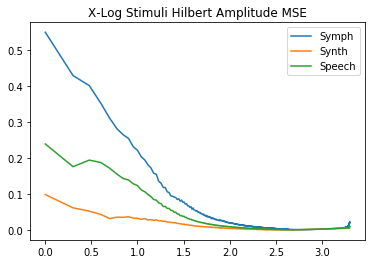

In [63]:
plt.plot(np.log10(range(1,2001)),amp1[0:2000],np.log10(range(1,2001)),amp2[0:2000],np.log10(range(1,2001)),amp3[0:2000])
plt.legend(['Symph','Synth','Speech'])
plt.title('X-Log Stimuli Hilbert Amplitude MSE')

Text(0.5, 1.0, 'Log-Log Stimuli Hilbert Amplitude MSE')

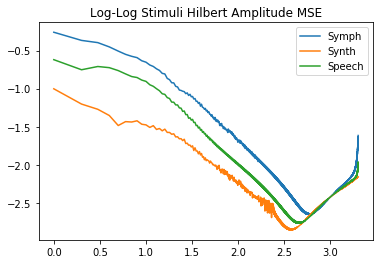

In [64]:
plt.plot(np.log10(range(1,2001)),np.log10(amp1[0:2000]),np.log10(range(1,2001)),np.log10(amp2[0:2000]),np.log10(range(1,2001)),np.log10(amp3[0:2000]))
plt.legend(['Symph','Synth','Speech'])
plt.title('Log-Log Stimuli Hilbert Amplitude MSE')

Text(0.5, 1.0, 'X-Log Stimuli Hilbert Amplitude MSE')

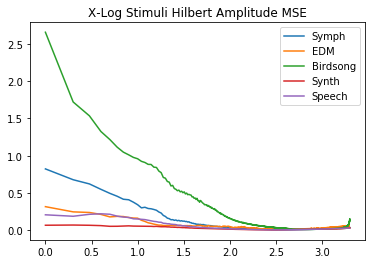

In [78]:
plt.plot(np.log10(range(1,2001)),amp_1[0:2000],np.log10(range(1,2001)),amp_2[0:2000],np.log10(range(1,2001)),amp_3[0:2000],np.log10(range(1,2001)),amp_4[0:2000],np.log10(range(1,2001)),amp_5[0:2000])
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('X-Log Stimuli Hilbert Amplitude MSE')

Text(0.5, 1.0, 'Log-Log Stimuli Hilbert Amplitude MSE')

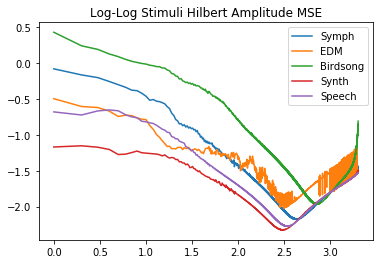

In [79]:
plt.plot(np.log10(range(1,2001)),np.log10(amp_1[0:2000]),np.log10(range(1,2001)),np.log10(amp_2[0:2000]),np.log10(range(1,2001)),np.log10(amp_3[0:2000]),np.log10(range(1,2001)),np.log10(amp_4[0:2000]),np.log10(range(1,2001)),np.log10(amp_5[0:2000]))
plt.legend(['Symph','EDM','Birdsong','Synth','Speech'])
plt.title('Log-Log Stimuli Hilbert Amplitude MSE')

## EEG MSE

In [131]:
import pandas as pd

## EDM

In [132]:
cl3_edm = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c3_edm.csv",header=None)
cl4_edm = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c4_edm.csv",header=None)

In [133]:
cl3_edm.head()

,0,1,2,3,4,5,6,7,8,9,...,266230,266231,266232,266233,266234,266235,266236,266237,266238,266239
0,-1.4084,2.01800,2.24680,1.11390,3.028700,4.46840,-0.057275,-3.4469,-0.27932,-1.75530,...,-1.109500,-0.66430,-0.61883,0.38401,-0.67909,-1.2342,-0.94731,-1.5327,-1.3791,-1.9026
1,3.2801,3.11470,2.25450,0.76060,0.794930,-0.35869,-0.116960,1.5755,0.43130,-0.13057,...,3.248500,1.79930,0.95694,1.21360,1.27250,3.6431,3.67020,2.0686,2.7271,2.1236
2,-1.5114,-1.05650,-1.31940,-0.70268,0.235820,-0.82525,-1.116700,-0.2062,-0.16636,0.74847,...,0.014567,-0.54429,-0.50952,-0.91503,-1.46820,-1.4586,-0.55420,1.0971,1.0542,1.3090
3,-1.1762,-0.89563,-0.98225,-0.21021,-0.019033,-0.24443,-0.816180,-1.0199,-0.24359,-0.75794,...,-0.513500,-0.61793,-1.69090,-1.11570,-2.24060,-2.6996,-2.08260,-2.0021,-1.9214,-1.5384
4,4.8976,4.23260,3.77190,3.39340,4.726600,6.00000,5.555600,4.7609,4.40160,1.63310,...,-4.187400,-6.61510,-7.45040,-7.12440,-6.89600,-5.9814,-7.12750,-8.7196,-6.3090,-6.2044


In [134]:
cl4_edm.head()

,0,1,2,3,4,5,6,7,8,9,...,266230,266231,266232,266233,266234,266235,266236,266237,266238,266239
0,0.57656,-0.16964,0.16948,0.50404,1.06260,0.40353,0.63890,1.49310,1.3455,1.0788,...,-5.0422,-5.56420,-4.39410,-4.83490,-4.91520,-6.507000,-5.9370,-4.8537,-5.27570,-4.32110
1,6.17060,7.13050,7.09730,6.80920,6.27930,6.18750,5.03280,3.93680,5.0382,4.3347,...,-1.1289,-2.09840,-3.28800,-0.82038,-2.12970,-2.430800,-0.9162,-1.5727,-3.15600,-1.56800
2,3.24280,3.42640,3.54930,3.57100,4.63160,4.36010,2.34500,3.08850,2.6444,2.3689,...,2.9424,2.20470,1.87080,2.65460,0.55794,-0.042419,1.9996,3.2835,3.04090,1.98180
3,-0.77023,-0.37778,-0.69939,-1.13380,-1.10740,-1.17050,-0.60826,0.10262,-0.9250,-1.6454,...,0.1206,-1.28500,-0.74954,-1.28110,-1.88730,-1.535000,-3.5090,-2.4130,-0.87516,-1.55870
4,0.38168,-0.74065,-1.04130,-1.11660,-0.69373,-0.15958,-2.24980,-3.51300,-2.6037,-1.8910,...,-1.1866,-0.80578,-0.43930,-0.54483,-0.98391,-0.609310,-0.3621,-1.2980,-0.60413,-0.13565


In [112]:
comp1 = cl3_edm.loc[0,:].values
comp2 = cl4_edm.loc[0,:].values

In [135]:
#cl3_mse = []
cl4_mse = []

for i in range(len(cl3_edm)):
    cl3_mse.append(multiscale_entropy( cl3_edm.loc[i,:].values, 3, None, 2048))
    
for i in range(len(cl4_edm)):
    cl4_mse.append(multiscale_entropy( cl4_edm.loc[i,:].values, 3, None, 2048))

17:33:22
17:40:16
17:40:23
17:40:26
17:40:29
17:40:31
17:40:33
17:40:34
17:40:35
17:40:36
17:40:37
17:40:38
17:40:39
17:40:39
17:40:40
17:40:41
17:40:41


C:\Users\cogmech\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log


17:40:42
17:40:42
17:40:43
17:40:44
17:40:44
17:50:17
17:50:25
17:50:29
17:50:32
17:50:35
17:50:36
17:50:38
17:50:40
17:50:41
17:50:42
17:50:43
17:50:44
17:50:45
17:50:46
17:50:47
17:50:48
17:50:49
17:50:49
17:50:50
17:50:51
17:50:51
18:00:28
18:00:36
18:00:40
18:00:43
18:00:45
18:00:47
18:00:49
18:00:50
18:00:52
18:00:53
18:00:54
18:00:55
18:00:56
18:00:57
18:00:57
18:00:58
18:00:59
18:01:00
18:01:01
18:01:01
18:01:02
18:11:12
18:11:19
18:11:24
18:11:27
18:11:29
18:11:31
18:11:33
18:11:34
18:11:36
18:11:37
18:11:38
18:11:39
18:11:40
18:11:41
18:11:42
18:11:43
18:11:44
18:11:45
18:11:45
18:11:46
18:11:47
18:19:51
18:19:57
18:20:01
18:20:04
18:20:06
18:20:07
18:20:09
18:20:10
18:20:11
18:20:12
18:20:12
18:20:13
18:20:14
18:20:15
18:20:15
18:20:16
18:20:17
18:20:17
18:20:18
18:20:18
18:20:19
18:27:24
18:27:31
18:27:35
18:27:37
18:27:39
18:27:41
18:27:42
18:27:43
18:27:44
18:27:45
18:27:46
18:27:47
18:27:48
18:27:49
18:27:49
18:27:50
18:27:51
18:27:51
18:27:52
18:27:52
18:27:53
18:35:06
1

In [138]:
len(cl3_mse)

22

In [113]:
comp1_mse = multiscale_entropy(comp1, 3, None, 2048)
comp2_mse = multiscale_entropy(comp2, 3, None, 2048)

19:44:16
19:51:15
19:51:22
19:51:26
19:51:28
19:51:30
19:51:32
19:51:33
19:51:34
19:51:35
19:51:36
19:51:37
19:51:38
19:51:39
19:51:40
19:51:40
19:51:41
19:51:42
19:51:42
19:51:43
19:51:43
19:51:44
19:59:45
19:59:53
19:59:57
19:59:59
20:00:02
20:00:03
20:00:05
20:00:06
20:00:07
20:00:08
20:00:09
20:00:10
20:00:11
20:00:12
20:00:13
20:00:14


C:\Users\cogmech\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log


20:00:15
20:00:15
20:00:16
20:00:17


Text(0.5, 1.0, 'Log-Log EEG Component EDM Condition MSE')

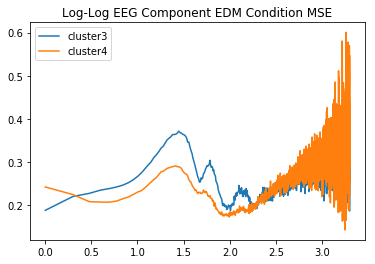

In [117]:
plt.plot(np.log10(range(1,2001)),np.log10(comp1_mse[0:2000]),np.log10(range(1,2001)),np.log10(comp2_mse[0:2000]))
plt.legend(['cluster3','cluster4'])
plt.title('Log-Log EEG Component EDM Condition MSE')

Text(0.5, 1.0, 'Log-Log EEG Component EDM Condition MSE')

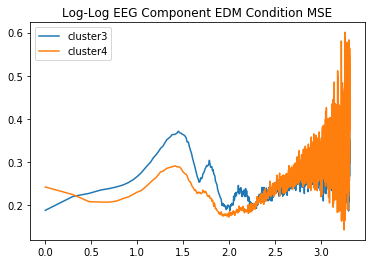

In [137]:
plt.plot(np.log10(range(1,2049)),np.log10(cl3_mse[0]),np.log10(range(1,2049)),np.log10(cl4_mse[0]))
plt.legend(['cluster3','cluster4'])
plt.title('Log-Log EEG Component EDM Condition MSE')

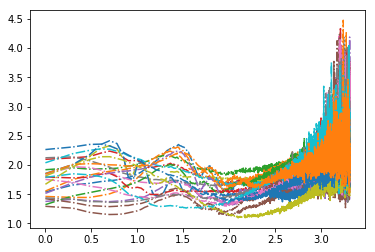

In [147]:
plt.figure()

for i in range(len(cl3_mse)):
    plt.plot(np.log10(range(1,2049)), cl3_mse[i],'-.')

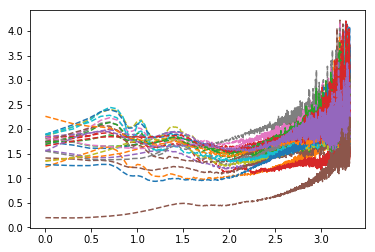

In [148]:
plt.figure()

for i in range(len(cl4_mse)):
    plt.plot(np.log10(range(1,2049)), cl4_mse[i],'--')

In [ ]:
cl3_mseidx = [2,2,3,1,3,2,1,3,3,1,1]
cl4_mseidx = [1,3,2,2,3,1,2,4,3,2,3]

In [158]:
mean1 = np.mean(cl3_mse[0:2], axis=0)
mean2 = np.mean(cl3_mse[2:4], axis=0)
mean3 = np.mean(cl3_mse[4:7], axis=0)
mean4 = cl3_mse[7]
mean5 = np.mean(cl3_mse[8:11], axis=0)
mean6 = np.mean(cl3_mse[11:13], axis=0)
mean7 = cl3_mse[13]
mean8 = np.mean(cl3_mse[14:17], axis=0)
mean9 = np.mean(cl3_mse[17:20], axis=0)
mean10 = cl3_mse[20]
mean11 = cl3_mse[21]

cl3_partmse = [mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,mean9,mean10,mean11]

In [175]:
mean1 = cl4_mse[0]
mean2 = np.mean(cl4_mse[1:4], axis=0)
mean3 = np.mean(cl4_mse[4:6], axis=0)
mean4 = np.mean(cl4_mse[6:7], axis=0)
mean5 = np.mean(cl4_mse[7:10], axis=0)
mean6 = cl4_mse[11]
mean7 = np.mean(cl4_mse[12:14], axis=0)
mean8 = np.mean(cl4_mse[14:18], axis=0)
mean9 = np.mean(cl4_mse[18:21], axis=0)
mean10 = np.mean(cl4_mse[21:23], axis=0)
mean11 = np.mean(cl4_mse[23:27], axis=0)

cl4_partmse = [mean1,mean2,mean3,mean4,mean5,mean6,mean7,mean8,mean9,mean10,mean11]

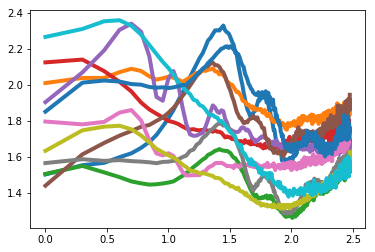

In [173]:
cl3_partmse = np.array(cl3_partmse)
plt.figure()

for i in range(len(cl3_partmse)):
    plt.plot(np.log10(range(1,300)), cl3_partmse[i,0:299], linewidth=4)

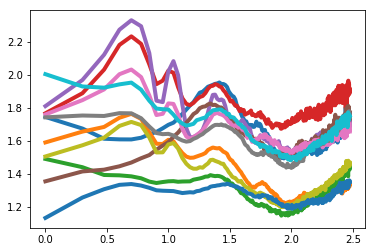

In [176]:
cl4_partmse = np.array(cl4_partmse)
plt.figure()

for i in range(len(cl4_partmse)):
    plt.plot(np.log10(range(1,300)), cl4_partmse[i,0:299], linewidth=4)

Text(0.5, 1.0, 'EDM Mean MSE')

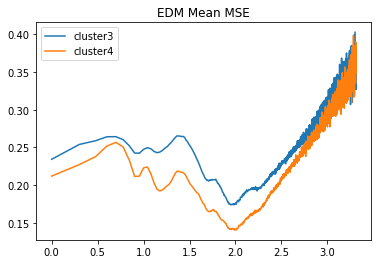

In [195]:
cl3_edmmean = np.mean(cl3_mse, axis=0)
cl4_edmmean = np.mean(cl4_mse, axis=0)

plt.plot(np.log10(range(1,2049)),np.log10(cl3_edmmean),np.log10(range(1,2049)),np.log10(cl4_edmmean))
plt.legend(['cluster3','cluster4'])
plt.title('EDM Mean MSE')

Text(0.5, 1.0, 'EDM Mean MSE')

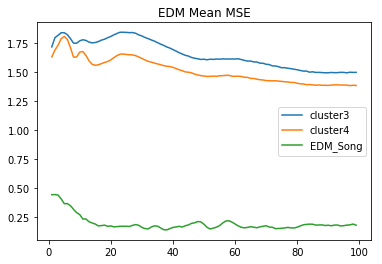

In [201]:
plt.plot(range(1,80),cl3_edmmean[0:79],range(1,80),cl4_edmmean[0:99],range(1,100),mse2[0:99])
plt.legend(['cluster3','cluster4','EDM_Song'])
plt.title('EDM Mean MSE')

## Ted

In [178]:
cl3_ted = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c3_ted.csv",header=None)
cl4_ted = pd.read_csv("/Users/cogmech/Documents/Neuro Complexity Matching/comps/comps/c4_ted.csv",header=None)

In [179]:
cl3_tedmse = []
cl4_tedmse = []

for i in range(len(cl3_ted)):
    cl3_tedmse.append(multiscale_entropy( cl3_ted.loc[i,:].values, 3, None, 2048))
    
for i in range(len(cl4_ted)):
    cl4_tedmse.append(multiscale_entropy( cl4_ted.loc[i,:].values, 3, None, 2048))

19:05:23
19:12:54
19:13:01
19:13:05
19:13:07
19:13:09
19:13:11
19:13:12
19:13:13
19:13:14
19:13:15
19:13:16
19:13:17
19:13:18
19:13:18
19:13:19
19:13:20
19:13:20
19:13:21
19:13:22
19:13:22
19:13:23
19:22:04
19:22:12
19:22:16
19:22:19
19:22:21
19:22:23
19:22:25
19:22:26
19:22:28
19:22:29
19:22:30
19:22:31
19:22:32
19:22:33
19:22:33
19:22:34
19:22:35
19:22:36
19:22:37
19:22:37
19:22:38
19:30:17
19:30:23
19:30:27
19:30:29
19:30:31
19:30:33
19:30:34
19:30:35
19:30:36
19:30:37
19:30:38
19:30:39
19:30:40
19:30:40
19:30:41
19:30:42
19:30:42
19:30:43
19:30:44
19:30:44
19:30:44
19:38:49
19:38:56
19:39:01
19:39:04
19:39:06
19:39:08
19:39:09
19:39:11
19:39:12
19:39:13
19:39:14
19:39:15
19:39:16
19:39:17
19:39:18
19:39:19
19:39:20
19:39:21
19:39:21
19:39:22
19:39:22
19:48:56
19:49:03
19:49:08
19:49:11
19:49:13
19:49:15
19:49:16
19:49:18
19:49:19
19:49:20
19:49:21
19:49:22
19:49:23
19:49:24
19:49:24
19:49:25
19:49:26
19:49:27
19:49:28
19:49:28
19:49:29
19:59:01
19:59:08
19:59:13
19:59:16
19:59:18
1

C:\Users\cogmech\Anaconda3\lib\site-packages\ipykernel_launcher.py:157: RuntimeWarning: divide by zero encountered in log


19:59:33
19:59:34
20:09:02
20:09:09
20:09:14
20:09:17
20:09:19
20:09:21
20:09:22
20:09:24
20:09:25
20:09:26
20:09:27
20:09:28
20:09:29
20:09:30
20:09:31
20:09:32
20:09:32
20:09:33
20:09:34
20:09:35
20:09:35
20:18:09
20:18:16
20:18:20
20:18:22
20:18:24
20:18:26
20:18:27
20:18:28
20:18:29
20:18:30
20:18:31
20:18:31
20:18:32
20:18:33
20:18:33
20:18:34
20:18:35
20:18:35
20:18:36
20:18:36
20:18:37
20:25:54
20:26:02
20:26:06
20:26:10
20:26:12
20:26:14
20:26:15
20:26:17
20:26:18
20:26:19
20:26:21
20:26:22
20:26:23
20:26:24
20:26:25
20:26:25
20:26:26
20:26:27
20:26:28
20:26:29
20:26:29
20:36:08
20:36:16
20:36:20
20:36:23
20:36:25
20:36:27
20:36:29
20:36:31
20:36:32
20:36:33
20:36:34
20:36:35
20:36:36
20:36:37
20:36:38
20:36:39
20:36:40
20:36:41
20:36:41
20:36:42
20:36:43
20:46:15
20:46:24
20:46:28
20:46:31
20:46:34
20:46:36
20:46:37
20:46:39
20:46:40
20:46:42
20:46:43
20:46:44
20:46:45
20:46:46
20:46:47
20:46:48
20:46:49
20:46:49
20:46:50
20:46:51
20:46:51
20:56:37
20:56:45
20:56:49
20:56:52
2

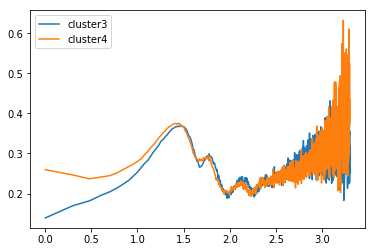

In [181]:
cl3_tedmse = np.array(cl3_tedmse)
cl4_tedmse = np.array(cl4_tedmse)

plt.plot(np.log10(range(1,2001)),np.log10(cl3_tedmse[0,0:2000]),np.log10(range(1,2001)),np.log10(cl4_tedmse[0,0:2000]))
plt.legend(['cluster3','cluster4'])

In [188]:
cl3_tedmean = np.mean(cl3_tedmse, axis=0)
cl4_tedmean = np.mean(cl4_tedmse, axis=0)

cl3_tedmean

array([1.71318793, 1.76806767, 1.77387314, ..., 2.1662221 , 2.13502347,
       2.09353983])

Text(0.5, 1.0, 'TED Mean MSE')

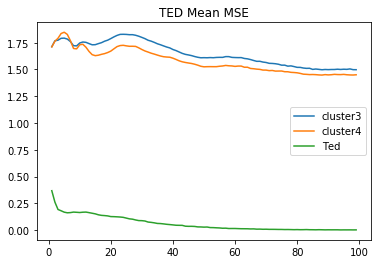

In [204]:
plt.plot(range(1,100),cl3_tedmean[0:99],range(1,100),cl4_tedmean[0:99],range(1,100),mse5[0:99])
plt.legend(['cluster3','cluster4','Ted'])
plt.title('TED Mean MSE')

## Stimuli Replication Procedure

In [205]:
#Assumed Params: stimuli sample rate = 512, m=2, r=.5

In [4]:
from scipy import signal

stim1 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Philip_Glass_Glassworks_01_Opening.wav")
sarr1 = np.array(stim1[1],dtype=float)
sarr1 = np.mean(sarr1,axis=1)
sarr1 = signal.resample(sarr1, 1856000) #512*samples per second



C:\Users\cogmech\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2223: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\cogmech\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  Y[sl] = X[sl]
C:\Users\cogmech\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:2230: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array inde

In [9]:
stim2 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/monteverdi_zefiro_torna.wav")
sarr2 = np.array(stim2[1],dtype=float)
sarr2 = np.mean(sarr2,axis=1)
sarr2 = signal.resample(sarr2, 4450000) #512*samples per second

stim3 = read("/Users/cogmech/Documents/Neuro Complexity Matching/mse_eeg_study/arx_study/stimuli/Praeambulum_F.wav")
sarr3 = np.array(stim3[1],dtype=float)
sarr3 = np.mean(sarr3,axis=1)
sarr3 = signal.resample(sarr3, 1230000) #512*samples per second

In [10]:
len(sarr2)

4450000

In [230]:
sarr1_mse = multiscale_entropy(sarr1, 2, None, 100) ##hard coded change to .5 on tolerance

15:31:40


In [11]:
sarr2_mse = multiscale_entropy(sarr2[0:1000000], 2, None, 100) ##hard coded change to .5 on tolerance
sarr3_mse = multiscale_entropy(sarr3[0:1000000], 2, None, 100) ##hard coded change to .5 on tolerance

08:53:41
13:15:03


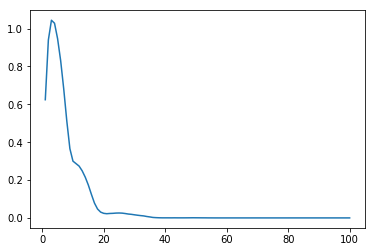

In [232]:
plt.plot(range(1,101),sarr1_mse)

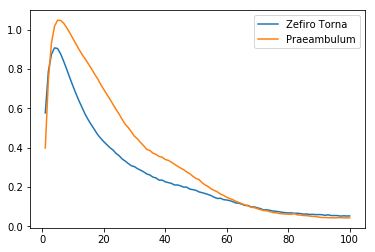

In [14]:
plt.plot(range(1,101),sarr2_mse, range(1,101), sarr3_mse)
plt.legend(['Zefiro Torna','Praeambulum'])

In [ ]:
#44khz/ms , 